<a href="https://colab.research.google.com/github/KLeeDE/PUS2020_KLee/blob/master/HW6/DEelectoralHW6_Kyungmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start from your HW5 (or from the solution posted)

The HW5 solution follows. Some of the tasks to are done differently than I would have if I had only the HW5 tasks to do. Those things are outlined below and they are generally in cells of code that need to be finished. The HW6 tasks proper start below ehre it says "**This is where HW2 starts**"

You will need to rerun it and make dure that 
- there are no nan values. Since a lot of the analysis you do relies on population density this will have to be done by **removing areas of 0 population** 
- after you remove precints fix the index by calling ```df_.reset_index(inplace=True)``` on your dataframe so that it does not have missing value. if it did you would be in trouble after creating the weight: you would get a missing index value (I got it for index 274) and also you might have troubles when fitting a line to the Moran's I
- make sure you convert the dataframe to feet (epsg=2263) and work your spatial analysis in feet (there is one point in which I will give you the coordinates of a specific locatoin in lat and lon: you need to either convert those in feet or reconvert temporarily the dataframe to lat-lon to do that part of the analysis)
- make sure you select a single race! the vanilla analysis we did in HW5 could work with summing all the races, but if we want to really look at voters turout, and especially voter turnout by political party and analyze blue and red votes separately, we need to make sure we do not doublecount. I chose the U.S. Senate race. If this were a real project you would need to check if choosing another rate changes your result.

NOTE: I care mostly about the interpretation of the figures in this notebook more than ever! if you cannot get a piece of code to reproduce the figure ask me. I do want you to try (so I want you to ask for it on a step by step basis), but I am happy to show you the solution. I really care about the considerations and interpretation tho!


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as plt
import shapely

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
!pip install geopandas

     |████████████████████████████████| 972kB 7.7MB/s 
     |████████████████████████████████| 10.9MB 14.9MB/s 
     |████████████████████████████████| 14.8MB 245kB/s 


In [4]:
!pip install -U --no-deps mapclassify git+git://github.com/geopandas/geopandas.git@master


  Cloning git://github.com/geopandas/geopandas.git (to revision master) to /tmp/pip-req-build-fyerjvp7
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-fyerjvp7
  Created wheel for geopandas: filename=geopandas-0.8.0+53.g7044aa4-py2.py3-none-any.whl size=969259 sha256=2141c201c4ccd2d74b92b37872b235be8f8fbb5d3ed1c926a2c64185cc7e093a
  Stored in directory: /tmp/pip-ephem-wheel-cache-0tt21wi_/wheels/1e/57/dc/7a5ea8503aefb23576c42181adfca7fc173fde5b71900660bc
Successfully built geopandas
  Found existing installation: geopandas 0.8.1
    Uninstalling geopandas-0.8.1:
      Successfully uninstalled geopandas-0.8.1


In [5]:
!apt install libspatialindex-c4v5
!pip install pysal

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 270 kB of archives.
After this operation, 1,107 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Fetched 270 kB in 0s (2,935 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_amd64.deb ...
Unpacking libspatialindex4v5:amd64 (1.8.5-5) ...
Selecting previously unselected package libspatialindex-c4v5:amd64.
Preparing to 

In [6]:
import geopandas as gpd

In [7]:
import pysal as ps

Use the delaware opendata to extract the voting precincts geometries

https://opendata.firstmap.delaware.gov/datasets/delaware-election-boundaries

USe the election data from the turnout project to get the precinct turnout

https://raw.githubusercontent.com/openelections/openelections-data-de/master/2018/20181106__de__general__precinct.csv

# read in data

## read in electoral precinct geojson file in geopandas (directly from the URL)

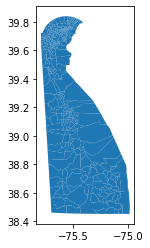

In [8]:
# leave
de_elecp = gpd.read_file("https://opendata.arcgis.com/datasets/91c1f132c7d34885983c56b47dc675fd_0.geojson")
de_elecp.plot();

In [9]:
# leave
de_elecp.head()

,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry
0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746..."
1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760..."
2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686..."
3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661..."
4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658..."


In [10]:
# leave
de_elecp.describe()

,OBJECTID,ID,POPULATION
count,430.000000,430.000000,430.000000
mean,215.500000,216.500000,2088.218605
std,124.274562,124.274562,998.347223
min,1.000000,2.000000,0.000000
25%,108.250000,109.250000,1484.750000
50%,215.500000,216.500000,2141.500000
75%,322.750000,323.750000,2659.750000
max,430.000000,431.000000,7734.000000


## read in turnout data - keep only election district, and votes


In [11]:
# leave
# turnout = pd.read.....
turnout = pd.read_csv("https://raw.githubusercontent.com/openelections/openelections-data-de/master/2018/20181106__de__general__precinct.csv")

turnout["office"].unique()
turnout = turnout[turnout["office"] == "U.S. Senate"]
turnout = turnout[["party", "election_district", "votes"]]
turnout

,party,election_district,votes
0,DEMOCRATIC,01-01,581
1,REPUBLICAN,01-01,51
2,GREEN,01-01,5
3,LIBERTARIN,01-01,6
4,DEMOCRATIC,02-01,937
...,...,...,...
1743,LIBERTARIN,16-41,0
1744,DEMOCRATIC,Total,217385
1745,REPUBLICAN,Total,137127
1746,GREEN,Total,4170


## group by election district and get the total number of data for that district

there are multiple entries for each geometry because there entries indicate the votes per candidate.


In [12]:
# leave
turnout.groupby(["election_district", "party"]).sum()[["votes"]]

votes
election_district party             
01-01             DEMOCRATIC     581
                  GREEN            5
                  LIBERTARIN       6
                  REPUBLICAN      51
01-02             DEMOCRATIC     694
...                              ...
17-02             REPUBLICAN      14
Total             DEMOCRATIC  217385
                  GREEN         4170
                  LIBERTARIN    3910
                  REPUBLICAN  137127

[1748 rows x 1 columns]

## merge the turnout data with the electoral map


* there are no nan values. Since a lot of the analysis you do relies on population density this will have to be done by removing areas of 0 population

* after you remove precints fix the index by calling df_.reset_index(inplace=True) on your dataframe so that it does not have missing value. if it did you would be in trouble after creating the weight: you would get a missing index value (I got it for index 274) and also you might have troubles when fitting a line to the Moran's I

In [13]:
de_elecmap = de_elecp.merge(turnout.groupby("election_district").sum()[["votes"]], 
                            left_on="EDRD_2012", right_index=True, how="left")

In [14]:
# leave this cell to showreset_index
no0votesindx = de_elecmap.POPULATION > 0
de_elecmap = de_elecmap[no0votesindx]
de_elecmap.reset_index(inplace=True)

In [15]:
# leave this cell to show
# note you have 428 precincts with indices 0-427
de_elecmap

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes
0,0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746...",528.0
1,1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760...",1109.0
2,2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686...",185.0
3,3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661...",892.0
4,4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658...",682.0
...,...,...,...,...,...,...,...,...,...
423,425,426,424,08-38,2042,38,None,"POLYGON ((-75.12161 38.45119, -75.12186 38.451...",1197.0
424,426,427,425,08-40,1684,40,None,"POLYGON ((-75.43038 38.65207, -75.43017 38.651...",598.0
425,427,428,426,08-41,2785,41,None,"POLYGON ((-75.36290 38.58543, -75.36268 38.585...",531.0
426,428,429,427,09-20,414,20,None,"POLYGON ((-75.27245 38.80446, -75.27254 38.804...",247.0


## make 3 maps: a coropleth of the population by electoral precinct, votes by precinct, and people density. 

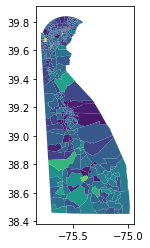

In [16]:
# leave
# exploratory plot
de_elecmap.plot(column="POPULATION");

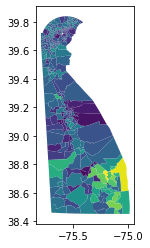

In [17]:
# leave
# exploratory plot
de_elecmap.plot(column="votes");

* make sure you convert the dataframe to feet (epsg=2263) and work your spatial analysis in feet (there is one point in which I will give you the coordinates of a specific locatoin in lat and lon: you need to either convert those in feet or reconvert temporarily the dataframe to lat-lon to do that part of the analysis)

In [18]:
de_elecmap_ft = de_elecmap.to_crs("EPSG:2263")
de_elecmap["popdensity"] = (de_elecmap.POPULATION / de_elecmap_ft.geometry.area * 5280 * 5280)

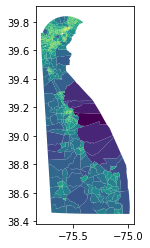

In [19]:
# leave
de_elecmap.plot(column="popdensity", 
                norm=matplotlib.colors.LogNorm());

## look at the variables' correlation


* make sure you select a single race! the vanilla analysis we did in HW5 could work with summing all the races, but if we want to really look at voters turout, and especially voter turnout by political party and analyze blue and red votes separately, we need to make sure we do not doublecount. I chose the U.S. Senate race. If this were a real project you would need to check if choosing another rate changes your result.

In [20]:
# leave
de_elecmap.corr()

,index,OBJECTID,ID,POPULATION,votes,popdensity
index,1.000000,1.000000,0.991604,0.040705,0.147145,-0.353621
OBJECTID,1.000000,1.000000,0.991604,0.040705,0.147145,-0.353621
ID,0.991604,0.991604,1.000000,0.038756,0.146066,-0.353507
POPULATION,0.040705,0.040705,0.038756,1.000000,0.647286,-0.036099
votes,0.147145,0.147145,0.146066,0.647286,1.000000,-0.242323
popdensity,-0.353621,-0.353621,-0.353507,-0.036099,-0.242323,1.000000


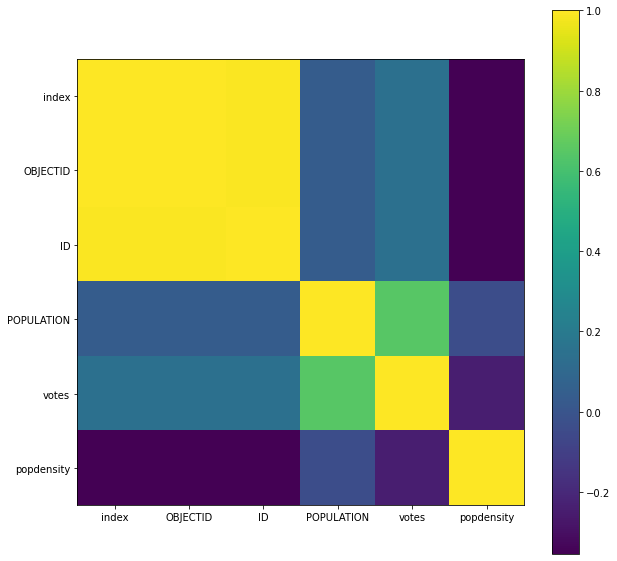

In [21]:
# leave
# Correlation matrix - we will discuss this kind of plot soon
plt.figure(figsize=(10,10))
plt.imshow(de_elecmap.corr())
plt.xticks(range(len(de_elecmap.corr())), de_elecmap.corr().columns)
plt.yticks(range(len(de_elecmap.corr())), de_elecmap.corr().columns)
plt.colorbar();


## fit a line model to the data and a polynomial of second degree. 

# extra credit: set up the problem as a machine leraning problem by splitting the sample into training and test data and evaluating the model on both sets.


In [22]:
# leave
import statsmodels.formula.api as smf
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
# leave
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
# leave
X_train, X_test, y_train, y_test = train_test_split(de_elecmap.POPULATION.values, 
                                                    de_elecmap.votes.values, test_size=0.25, 
                                                     random_state=302)
X_train

# or I can do
np.random.seed(302)
inds = np.sort(np.random.choice(de_elecmap.index, 
                                int(de_elecmap.shape[0] * 0.75), replace=False))

In [25]:
# remove
de_elecmap_train = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[inds].dropna()
de_elecmap_test = de_elecmap[["votes", "POPULATION", "popdensity"]].loc[
  np.array([i for i in de_elecmap.index if not i in inds ])].dropna()

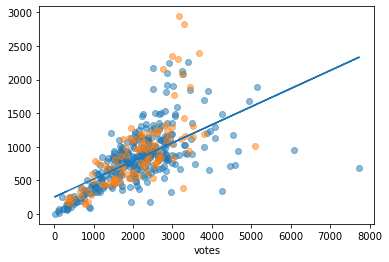

In [26]:
# remove
# these syntaxes are equivalent
# model1 = sm.OLS(y_train, X_train).fit()
model1 = smf.ols(formula = "votes ~ POPULATION", data=de_elecmap_train).fit()
ypred = model1.predict() 
plt.scatter(de_elecmap_train.POPULATION, de_elecmap_train.votes, alpha=0.5)
plt.scatter(de_elecmap_test.POPULATION, de_elecmap_test.votes, alpha=0.5);
plt.xlabel("population")
plt.xlabel("votes")
plt.plot(de_elecmap_train.POPULATION, ypred);

In [27]:
# remove
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     226.8
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           4.27e-39
Time:                        15:14:27   Log-Likelihood:                -2312.8
No. Observations:                 321   AIC:                             4630.
Df Residuals:                     319   BIC:                             4637.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    250.5485     41.578      6.026      0.000     168.747     332.350
POPULATION     0.2691      0.018     15.061      0.000       0.234       0.304
==============================================================================
Omnibus:                       40.869   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.758
Skew:                           0.335   Prob(JB):                     2.09e-45
Kurtosis:                       6.865   Cond. No.                     5.31e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     179.0
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.22e-53
Time:                        15:14:27   Log-Likelihood:                -2278.0
No. Observations:                 321   AIC:                             4562.
Df Residuals:                     318   BIC:                             4573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -80.5924     53.081     -1.518      0.130    -185.027      23.842
I(POPULATION ** 2) -6.594e-05   7.51e-06     -8.782      0.000   -8.07e-05   -5.12e-05
POPULATION             0.5982      0.041     14.672      0.000       0.518       0.678
==============================================================================
Omnibus:                       55.542   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.483
Skew:                           0.832   Prob(JB):                     2.31e-30
Kurtosis:                       5.727   Cond. No.                     2.51e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

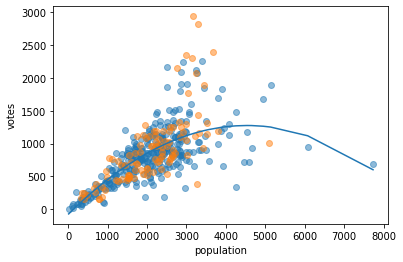

In [28]:
# remove
model2 = smf.ols(formula = "votes ~ I(POPULATION**2) + POPULATION", data=de_elecmap_train).fit()
ypred = model2.predict(de_elecmap_train.sort_values("POPULATION")) 
plt.scatter(de_elecmap_train.POPULATION, de_elecmap_train.votes, alpha=0.5)
plt.scatter(de_elecmap_test.POPULATION, de_elecmap_test.votes, alpha=0.5);
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap_train.sort_values("POPULATION").POPULATION, ypred);
model2.summary()

If you instead make a model based on population and population density, it is harder to visualize

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.56e-59
Time:                        15:14:27   Log-Likelihood:                -3095.2
No. Observations:                 428   AIC:                             6196.
Df Residuals:                     425   BIC:                             6209.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    284.3675     40.059      7.099      0.000     205.628     363.106
popdensity    -0.0230      0.004     -6.187      0.000      -0.030      -0.016
POPULATION     0.2962      0.016     18.042      0.000       0.264       0.328
==============================================================================
Omnibus:                       92.894   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.539
Skew:                           0.711   Prob(JB):                    2.23e-144
Kurtosis:                       8.922   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

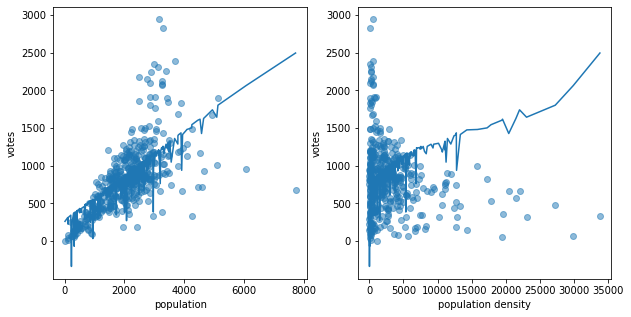

In [29]:
# remove
model3 = smf.ols(formula = "votes ~ popdensity + POPULATION", data=de_elecmap).fit()
ypred = model3.predict(de_elecmap.sort_values("POPULATION")) 
fig = plt.figure(figsize=(10,5))

fig.add_subplot(121)
plt.scatter(de_elecmap.POPULATION, de_elecmap.votes, alpha=0.5)
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap.sort_values("POPULATION").POPULATION, ypred);

fig.add_subplot(122)
plt.plot(de_elecmap.sort_values("popdensity").popdensity, ypred);
plt.scatter(de_elecmap.popdensity, de_elecmap.votes, alpha=0.5)
plt.xlabel("population density")
plt.ylabel("votes")
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  votes   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     186.2
Date:                Tue, 13 Oct 2020   Prob (F-statistic):           8.56e-59
Time:                        15:14:27   Log-Likelihood:                -3095.2
No. Observations:                 428   AIC:                             6196.
Df Residuals:                     425   BIC:                             6209.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    284.3675     40.059      7.099      0.000     205.628     363.106
popdensity    -0.0230      0.004     -6.187      0.000      -0.030      -0.016
POPULATION     0.2962      0.016     18.042      0.000       0.264       0.328
==============================================================================
Omnibus:                       92.894   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              661.539
Skew:                           0.711   Prob(JB):                    2.23e-144
Kurtosis:                       8.922   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

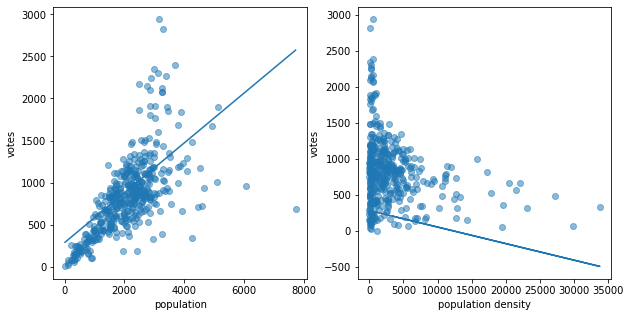

In [30]:
# remove
fig = plt.figure(figsize=(10,5))

fig.add_subplot(121)
plt.scatter(de_elecmap.POPULATION, de_elecmap.votes, alpha=0.5)
plt.xlabel("population")
plt.ylabel("votes")
plt.plot(de_elecmap.sort_values("POPULATION").POPULATION,
         model3.params[0] + de_elecmap.sort_values("POPULATION").POPULATION * model3.params[2]);

fig.add_subplot(122)
plt.plot(de_elecmap.sort_values("POPULATION").popdensity,
         model3.params[0] + de_elecmap.sort_values("POPULATION").popdensity * model3.params[1]);
plt.scatter(de_elecmap.popdensity, de_elecmap.votes, alpha=0.5)
plt.xlabel("population density")
plt.ylabel("votes")
model3.summary()

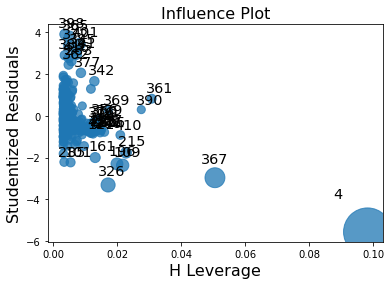

In [31]:
# remove
sm.graphics.influence_plot(model1);

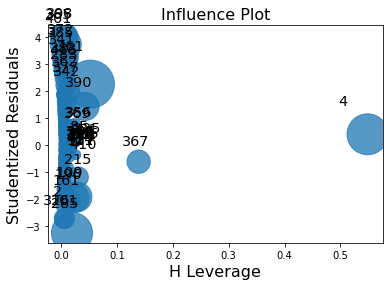

In [32]:
sm.graphics.influence_plot(model2);

## Compare the models with the Likelihood Ratio test (follow example in class)


In [33]:
#leave
from sklearn.metrics import r2_score 
# set alpha to 0.05
def printresult(r2, r, alpha=0.1):
  print("conveying {:d}% of the variance in the data and is".format(int(100 *r2)))
  if r < alpha:
    print("better than the first degree polynomial model (p-value {:.2f})".format(r))
  else: 
    print("too complex compared to the first degree polynomial model")

print("\nthe univariate line fit model is conveying {:d}% of the variance in the data".format(
    int(100 * r2_score(de_elecmap_test.dropna().votes, model1.predict(de_elecmap_test.dropna())))))
print("\nthe quadratic model is")
printresult(r2_score(de_elecmap_test.dropna().votes, model2.predict(de_elecmap_test.dropna())),
            model2.compare_lr_test(model1)[1])
print("\nthe multivariate model is")

printresult(r2_score(de_elecmap_test.dropna().votes, model3.predict(de_elecmap_test.dropna())),
            model3.compare_lr_test(model1)[1])


the univariate line fit model is conveying 39% of the variance in the data

the quadratic model is
conveying 44% of the variance in the data and is
better than the first degree polynomial model (p-value 0.00)

the multivariate model is
conveying 48% of the variance in the data and is
too complex compared to the first degree polynomial model


# This is where HW2 starts


## feature engineering
- create a "voterturnout" variable: the number of votes per person.

- create a "red votes" variable: the number of republican votes per person.

- create a "blue votes" variable: the number of democrat votes per person.

plot them as coropleths and comment on what you see

you want all the variable same the same geodataframe

In [34]:
dems = turnout[turnout.party == "DEMOCRATIC"]
reps = turnout[turnout.party == "REPUBLICAN"]

In [35]:
dems.columns = ["party", "election_district", "dems"]
reps.columns = ["party", "election_district", "reps"]

In [36]:
de_elecmap = de_elecmap.merge(dems, left_on = "EDRD_2012", right_on = "election_district")
de_elecmap = de_elecmap.merge(reps, left_on = "EDRD_2012", right_on = "election_district")

In [37]:
de_elecmap["votes"] = de_elecmap["dems"] + de_elecmap["reps"]
de_elecmap["voterturnout"] = de_elecmap["votes"] / de_elecmap["POPULATION"]
de_elecmap["bluevotes"] = de_elecmap["dems"] / de_elecmap["POPULATION"]
de_elecmap["redvotes"] = de_elecmap["reps"] / de_elecmap["POPULATION"]
de_elecmap.head()

,index,OBJECTID,ID,EDRD_2012,POPULATION,DISTRICT,EGIS_OWNERElection_ED_RD_2012AREA,geometry,votes,popdensity,party_x,election_district_x,dems,party_y,election_district_y,reps,voterturnout,bluevotes,redvotes
0,0,1,20,01-21,1171,21,None,"POLYGON ((-75.67816 39.74598, -75.67807 39.746...",523,3051.035117,DEMOCRATIC,01-21,353,REPUBLICAN,01-21,170,0.446627,0.301452,0.145175
1,1,2,21,01-22,1755,22,None,"POLYGON ((-75.72394 39.76115, -75.72393 39.760...",1082,1353.325230,DEMOCRATIC,01-22,671,REPUBLICAN,01-22,411,0.616524,0.382336,0.234188
2,2,3,22,01-23,1947,23,None,"POLYGON ((-75.73601 39.68660, -75.73603 39.686...",170,7024.074253,DEMOCRATIC,01-23,129,REPUBLICAN,01-23,41,0.087314,0.066256,0.021058
3,3,4,23,01-24,2828,24,None,"POLYGON ((-75.69655 39.66154, -75.69666 39.661...",860,2229.844811,DEMOCRATIC,01-24,582,REPUBLICAN,01-24,278,0.304102,0.205799,0.098303
4,4,5,24,01-25,7734,25,None,"POLYGON ((-75.75158 39.65865, -75.75109 39.658...",646,3461.239454,DEMOCRATIC,01-25,549,REPUBLICAN,01-25,97,0.083527,0.070985,0.012542


Text(0.5, 1.0, 'Democratic Voters in DE')

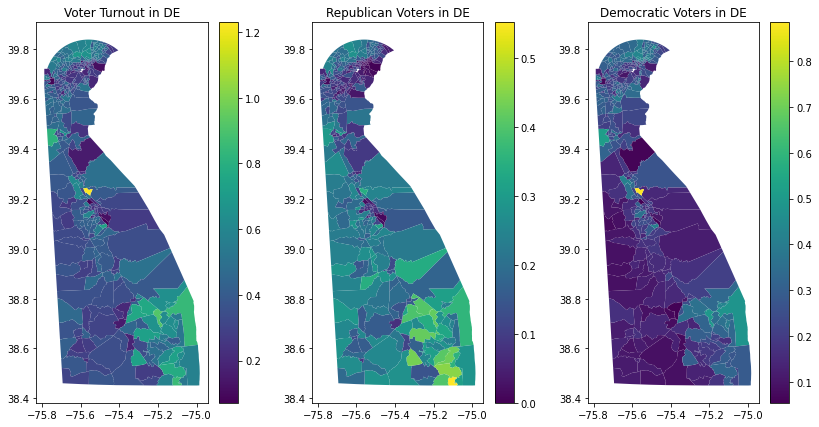

In [38]:
# plot it all and comment...

fig, ax = plt.subplots(1,3, figsize=[14,7])

de_elecmap.plot(column="voterturnout", ax=ax[0], legend=True);
ax[0].set_title("Voter Turnout in DE")

de_elecmap.plot(column="redvotes", ax=ax[1], legend=True);
ax[1].set_title("Republican Voters in DE")

de_elecmap.plot(column="bluevotes", ax=ax[2], legend=True);
ax[2].set_title("Democratic Voters in DE")

**Fig1. VOTER TURNOUT IN DELAWARE** The figure above shows the voter turnout, republican and democratic voters in Delaware respectively. The voter turnout is calculated as the number of votes per person. As the figure shown above,the highest rate of voter turnout is located in Sussex county. The Republican voters rate  shows the similar reult as the voter turnout. Otherwise, the rate of democratic voters is highest in Kent county. 

# create the rook and queens weights for the DE electoral map geoDF. 

you can do this by saving the df to a file and calling Rook.from_file (like in the class example) 
or you can use .from_iterable(geometry) passing the geometry series from the geoDF
(ask me if you are having a hard time...)

* Rook contiguity, i.e., when only common sides of the polygons are considered to define the neighbor relation (common vertices are ignored) 
* The difference between the rook and queen criterion to determine neighbors is that the latter also includes common vertices. 


In [39]:
from libpysal.weights import Queen, Rook

rook_DE = Rook.from_dataframe(de_elecmap)
queens_DE = Queen.from_dataframe(de_elecmap)

In [40]:
rook_DE.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0, 1.0],
 29: [1

In [41]:
queens_DE.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0,

## what is the electoral pricincts with most neighbouring ones? is it the same for Rook and Queens weights?

note: you can use the weights object cardinalities attribute, e.g.
```rook_DE.cardinalities```
this will return a dictionary. 
To find the maximum of a dictionary you can look here 
https://www.geeksforgeeks.org/python-get-key-with-maximum-value-in-dictionary/



In [42]:
rook_DE_cardi = rook_DE.cardinalities
queens_DE_cardi = queens_DE.cardinalities

In [43]:
import operator
RKeymax = max(rook_DE_cardi.items(), key=operator.itemgetter(1))[0] 
QKeymax = max(queens_DE_cardi.items(), key=operator.itemgetter(1))[0] 
print(RKeymax)
print(QKeymax)

9
49


are there isolated electoral precincts? you can find out with the attribute of the weights "island"


**Answer** There are no isolated electoral precincts, called "island", which shows as the blank bracket "[  ]". 

# challenge: wilmington center has coordinated 39.7447° N, 75.5484° W. 
find out in which precinct this location is (look at the first citibike notebook ) and find how many neighbors that precinct has in booth Rook and Queens weights


 https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html



In [44]:
from shapely.geometry import Point, Polygon

In [45]:
# combine lat and lon to one column
lonlat = lonlat = Point(-75.5484, 39.7447)
# Create Point Geometry for based on lonlat column
wilmington = shapely.geometry.Point(lonlat)

In [46]:
print(lonlat)

POINT (-75.5484 39.7447)


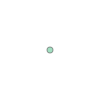

In [47]:
wilmington

In [48]:
wilmington.within(de_elecmap.loc[0].geometry)

False

In [49]:
wilmingtonpc = de_elecmap.geometry[de_elecmap.geometry.map(lambda geom: wilmington.within(geom))] 
wilmingtonpc

100    POLYGON ((-75.55499 39.75124, -75.55501 39.751...
Name: geometry, dtype: geometry

In [50]:
wilmingtonpcid = wilmingtonpc.index.values[0]

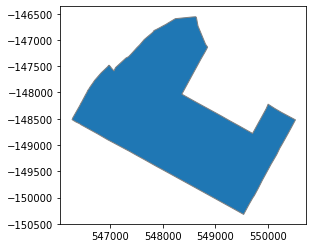

In [86]:
wilmingtonpc.to_crs(epsg=2263).plot(edgecolor='grey')

**Fig2. WILMINTON CENTER** This figure shows the center of Wilmington in Delaware, United States. The spatial unit is electoral precinct. 



## make a connection plot: plot the neighborhood of the Wilmington center precincts and the Rook and Queens weights on it. 


Reproduce the diagram that shows the connectivity of the precints, the "**weights ddiagrams **" (see notebook example https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/SpatialWeights_CitiBike.ipynb) can you see which neighbourhood assignments are different for the rook and the queens weights? can you tell why?


/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/p

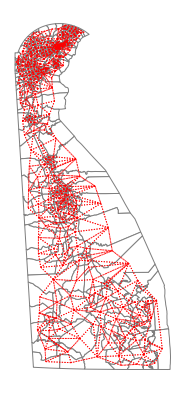

In [87]:
ax = de_elecmap.plot(edgecolor='grey', facecolor='w', figsize=(14,7))
f,ax = rook_DE.plot(de_elecmap, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

**Fig. Connection Plot (Rook weights)** This figure shows the connection plot of the neighborhood of the Delaware precincts baed on the Rook weights on it. The figure shows there are more connection in the New Castle county rather than Kent and Sussex counties. 

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/usr/local/lib/p

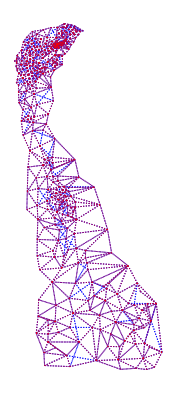

In [80]:
ax = wilmingtonpc.plot(edgecolor='grey', facecolor='w', figsize= (14,7))
f,ax = queens_DE.plot(de_elecmap, ax=ax,
        edge_kws=dict(color='b', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
f,ax = rook_DE.plot(de_elecmap, ax=ax,
        edge_kws=dict(color='r', linestyle=':', alpha=0.5, linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

**Fig. Connection Plot (Rook & Queens weights)** This figure shows the connection plot of the neighborhood of the Delaware precincts baed on the Rook and Queens weights on it. The figure shows there are more connection in the New Castle county rather than Kent and Sussex counties. The difference between Rook and Queens weights are the default criterion for contiguity on the lattice. It was that of the rook which takes as neighbors any pair of cells that share an edge. Alternatively, the queen criterion is used to include the vertices of the lattice to define contiguities. 

# create the spatial lag metrics and calculate the global Moran's I

In [53]:
import pysal.lib as ps

In [54]:
voterturnout = de_elecmap.voterturnout
redvotes = de_elecmap.redvotes
bluevotes = de_elecmap.bluevotes

voterturnoutlag = ps.weights.lag_spatial(queens_DE, voterturnout)
redvoteslag = ps.weights.lag_spatial(queens_DE, redvotes)
bluevoteslag = ps.weights.lag_spatial(queens_DE, bluevotes)

In [55]:
# leave - just checking
np.where(de_elecmap.voterturnout.isna())

(array([], dtype=int64),)

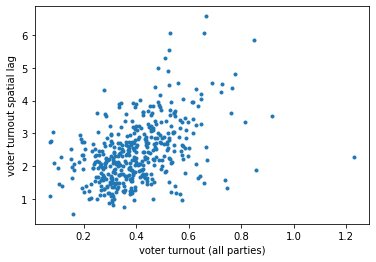

In [56]:
# leave
plt.plot(de_elecmap.voterturnout, voterturnoutlag, '.')
plt.xlabel("voter turnout (all parties)")
plt.ylabel("voter turnout spatial lag");

**Figure 3. Voter Turnout and Its Spatial Lag** Similarity of DE neighbors can be measured by means of spatial lag euqation:

$$Voter Turnout Spatial Lag = \sum_j w_{i,j} VoteTurnoutCount$$

The voter turnout and its spatial log shows positive relationship as the voter turnout increases the voter turnout spatial lag increases. However, there is a outlier in the right side which can deteriorate the positive relationship. 

In [57]:
ball, aall = np.polyfit(voterturnout, voterturnoutlag , 1)
br, ar = np.polyfit(redvotes, redvoteslag , 1)
bb, ab = np.polyfit(bluevotes, bluevoteslag , 1)
ball, aall                        

(2.8655067271792096, 1.2790912748495191)

## following the notebook example in class and the slides make a Moran'sI plot of each:
-all votes

-red votes

-blue votes

what do you notice?


In [78]:
isna = de_elecmap.voterturnout.isna()
# There are no nans in dataframe

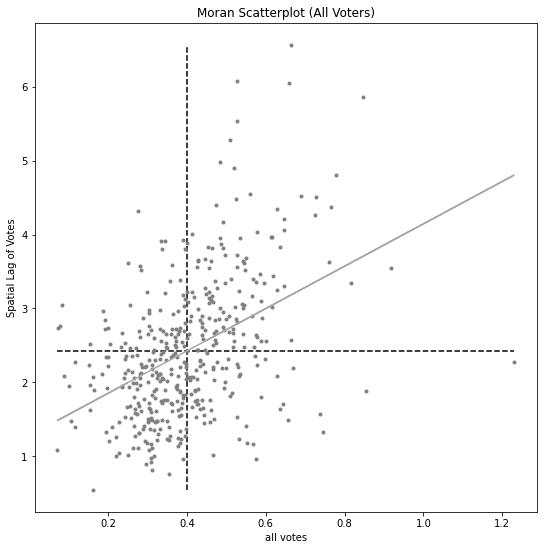

In [77]:
# i will give you the all voters example, work on the blue and red on your own
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(de_elecmap.voterturnout.values, voterturnoutlag, 
         '.', color='grey')

 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap.voterturnout.values.mean(), 
           voterturnoutlag.min(), 
           voterturnoutlag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(voterturnoutlag.mean(), 
           de_elecmap.voterturnout.values.min(), 
           de_elecmap.voterturnout.values.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(de_elecmap.voterturnout.values, 
         aall + ball * de_elecmap.voterturnout.values, 'darkgrey')
plt.title('Moran Scatterplot (All Voters)')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('all votes');

**Figure 4. Moran Scatterplot (All voters)** The figure is showing the scatter plots of Moran's I, which is a measure of spatial autocorrelation developed by Patrick Alfred Pierce Moran. The null hypothesis is the spatial randomness exists. In other words, it measures how one object is similar to others surrounding it. When values for neighboring fearues are either both larger than the mean or both smaller than the mean, the cross-product will be positive. 


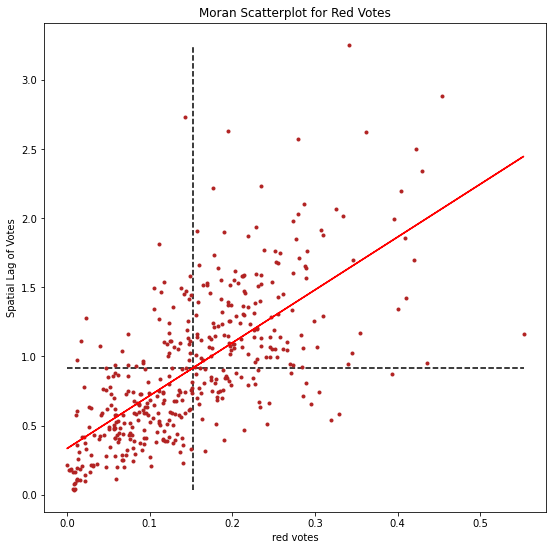

In [71]:
# Red votes Moran's I
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(de_elecmap.redvotes.values, redvoteslag, 
         '.', color='firebrick')
 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap.redvotes.values.mean(), 
           redvoteslag.min(), 
           redvoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(redvoteslag.mean(), 
           de_elecmap.redvotes.values.min(), 
           de_elecmap.redvotes.values.max(), linestyle='--')
# red line of best fit using global I as slope
plt.plot(de_elecmap.redvotes.values, 
         ar + br * de_elecmap.redvotes.values, 'r')
plt.title('Moran Scatterplot for Red Votes')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('red votes');

**Figure 5. Moran Scatterplot (Republican voters)** The figure is showing the scatter plots of Moran's I for republican voters. It measures how one object is similar to others surrounding it. As the figure shown above, the Moran's I shows positive which means neighboring fearues are either both larger than the mean or both smaller than the mean. Howver, there is an outlier at the right side in the figure which can affect the result of the Moran's I.

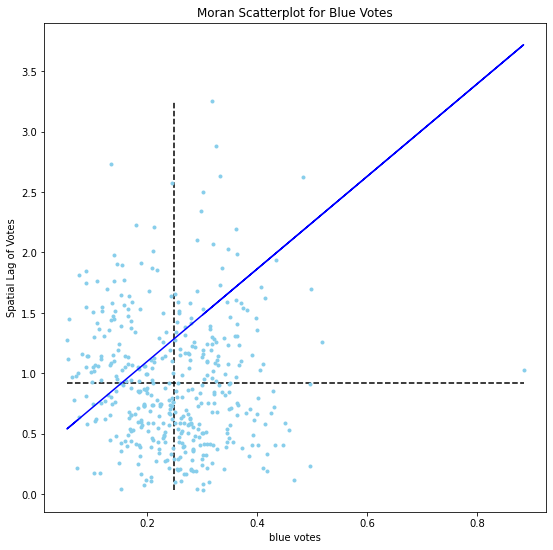

In [75]:
# Blue votes Moran's I
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(de_elecmap.bluevotes.values, redvoteslag, 
         '.', color='skyblue')
 # dashed vert at mean of the last year's PCI
plt.vlines(de_elecmap.bluevotes.values.mean(), 
           redvoteslag.min(), 
           redvoteslag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(redvoteslag.mean(), 
           de_elecmap.bluevotes.values.min(), 
           de_elecmap.bluevotes.values.max(), linestyle='--')
# red line of best fit using global I as slope
plt.plot(de_elecmap.bluevotes.values, 
         ar + br * de_elecmap.bluevotes.values, 'b')
plt.title('Moran Scatterplot for Blue Votes')
plt.ylabel('Spatial Lag of Votes')
plt.xlabel('blue votes');

**Figure 6. Moran Scatterplot (Democratic voters)** The figure is showing the scatter plots of Moran's I for democratic voters. It measures how one object is similar to others surrounding it. As the figure shown above, the Moran's I shows positive which means neighboring fearues are either both larger than the mean or both smaller than the mean. Howver, there is an outlier at the right side in the figure which can affect the result of the Moran's I. 

# Follow the notebook to complete the *local* spatial analysis. 
# how can you interpret these results ? (we will talk about it in class on Monday too)

In [60]:
from pysal.explore import esda

In [61]:
mi1 = esda.Moran(voterturnoutlag, queens_DE)
mi2 = esda.Moran(redvoteslag, queens_DE)
mi3 = esda.Moran(bluevoteslag, queens_DE)

In [62]:
for v, mi in zip(("all", "red", "blue"), (mi1, mi2, mi3)) :
  print("the global Moran's I for " + 
      "{} is {:.2f}\nwhich corresponds to a p-value of the spatial distribution being random {:.2g}".format(
   v, mi.I, mi.p_sim))

the global Moran's I for all is 0.29
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for red is 0.67
which corresponds to a p-value of the spatial distribution being random 0.001
the global Moran's I for blue is 0.42
which corresponds to a p-value of the spatial distribution being random 0.001


**what does this ^^^ statement actually mean in poorsman words? answer below**


The global Moran's I for all, red, and blue are 0.29, 0.67, and 0.42 repectively, and its p-values are 0.001. It means the ac actually observed value is Moaron's I. Also, the most extreme pseudo p-value possible under this scenario is 0.001 that none of the permuted data sets yielded a statistic larger than the one observed in the actual data.  

In [63]:
LMo_red = esda.Moran_Local(de_elecmap.redvotes.values, queens_DE, permutations=9999)

In [64]:
LMo_blue = esda.Moran_Local(de_elecmap.bluevotes.values, queens_DE, permutations=9999)

In [65]:
sig = LMo_red.p_sim < 0.01
hotspotsR = LMo_red.q==1 * sig
coldspotsR = LMo_red.q==3 * sig
print ("Number of Hotspots:", hotspotsR.sum())
print ("Number of Coldspots:", coldspotsR.sum())

Number of Hotspots: 36
Number of Coldspots: 59


In [66]:
sig = LMo_blue.p_sim < 0.01
hotspotsB = LMo_blue.q==1 * sig
coldspotsB = LMo_blue.q==3 * sig
print ("Number of Hotspots:", hotspotsB.sum())
print ("Number of Coldspots:", coldspotsB.sum())

Number of Hotspots: 35
Number of Coldspots: 49


hotcold = hotspotsB*1 + coldspotsB*2

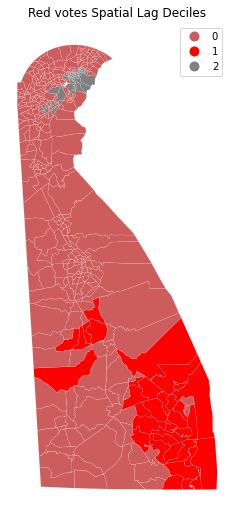

In [67]:
from matplotlib import colors

hcmap = colors.ListedColormap(['Indianred','red','grey'])
hotcold = hotspotsR*1 + coldspotsR*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=3, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Red votes Spatial Lag Deciles");

**Figure 7. Red botes Spatial Lag Deciles** This figure shows the spatial lag deciles of the republican votes in Delaware, United States. The spatial lag is a variable that averages the neighboring values of a location. Therefore, the result is dependent on its neighbors through the weights matrix. 1 is the most highest, and 2 is the lowest. The figure above shows that the right side of Sussex county shows the highest auto correlation with neighboring areas, and the Wilmington shows the lowest one. 

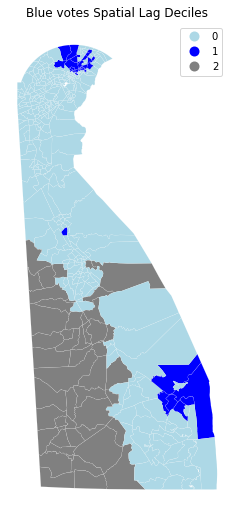

In [68]:
hcmap = colors.ListedColormap(['lightblue','blue','grey'])
hotcold = hotspotsB*1 + coldspotsB*2

f, ax = plt.subplots(figsize=(9, 9))
de_elecmap.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Blue votes Spatial Lag Deciles");

**Fig 8. Blue Votes Spatial Lag Deciles** This figure shows the spatial lag deciles of democratic votes in Delaware, United States. As the figure shown above, it shows the spatial correlation area. The Wilmington area and right side of the Sussex county shows the highest correlation, while the left side of the Delaware shows the lowest one.  

dont forget to comment on the plots!!